In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_expanded_feature_matrix, create_feature_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

def lasso_training(df, model, sliding_window, lag_price_window, DEBUG):
    """
    Train a lasso model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - model: The machine learning model to be trained (e.g., Lasso).
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = model  # This is done in order to use different model configurations of Lasso
    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_expanded_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        # Scale features for better convergence
        scaler = StandardScaler()
        X_train_fit_scaled = scaler.fit_transform(X_train_fit)
        X_to_predict_scaled = scaler.transform(X_to_predict)

        model.fit(X_train_fit_scaled, y_train_fit)
        y_predicted = model.predict(X_to_predict_scaled)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })

    return prediction_df



def lasso_training_gt(df, model, sliding_window, lag_price_window, DEBUG):
    """
    Train a lasso model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - model: The machine learning model to be trained (e.g., Lasso).
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = model  # This is done in order to use different model configurations of Lasso

    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        model.fit(X_train_fit, y_train_fit)
        y_predicted = model.predict(X_to_predict)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })

    return prediction_df

Baseline (Ground truth)

In [ ]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]

# Lasso regularization parameters
alphas = [0.01, 0.1, 1, 10, 100, 1000]

from sklearn.linear_model import Lasso
# Initialize the regression model
model = Lasso()

for alpha in alphas:
    # Initialize comprehensive results list
    comprehensive_baseline_results = []

    #if alpha has already been processed, skip - lasso_baseline_results_alpha_{alpha}.csv
    try:
        existing_results = pd.read_csv(f"lasso_baseline_results_alpha_{alpha}.csv")
        print(f"Results for alpha {alpha} already exist. Skipping...")
        continue
    except FileNotFoundError:
        print(f"No existing results for alpha {alpha}. Proceeding with training...")

    # Set the alpha parameter for Lasso
    model.set_params(alpha=alpha)
    print(f"\nRunning regression training with Lasso alpha: {alpha}")

    for sliding_window in sliding_windows:
        for lag_price_window in lag_price_windows:
            print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

            # Run the regression training
            prediction_df = lasso_training_gt(df, model, sliding_window, lag_price_window, DEBUG)

            # Calculate overall metrics
            actuals_list = prediction_df['Actual'].values
            predictions_list = prediction_df['Predicted'].values
            timestamps_list = prediction_df['Timestamp'].values

            mse = mean_squared_error(actuals_list, predictions_list)
            mae = mean_absolute_error(actuals_list, predictions_list)
            r2 = r2_score(actuals_list, predictions_list)

            # Calculate ES-like metric
            worst_overall_error_threshold   = np.percentile(np.abs(predictions_list - actuals_list), 5)  # worst 5% of errors
            worst_overall_indices = np.abs(predictions_list - actuals_list) >= worst_overall_error_threshold

            avg_worst_error = np.mean(np.abs(predictions_list[worst_overall_indices] - actuals_list[worst_overall_indices]))

            # Calculate prediction errors for filtering
            prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

            # Add overall results (100% percentile)
            comprehensive_baseline_results.append({
                'sliding_window': sliding_window,
                'lag_price_window': lag_price_window,
                'percentile': 100,
                'data_points': len(predictions_list),
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'worst_avg_error': avg_worst_error
            })

            for p in percentiles:
                # Filter by best predictions (lowest errors)
                best_error_threshold = np.percentile(prediction_errors, p)
                
                # Expectation Shortfall like metric - worst predictions analysis
                # Filter by best predictions (highest errors)
                worst_error_threshold = np.percentile(prediction_errors, 100 - p) # equivalent to worst_percentiles

                # Get indices of best/worst predictions 
                best_indices = prediction_errors <= best_error_threshold # with errors below threshold
                worst_indices = prediction_errors >= worst_error_threshold # with errors above threshold

                filtered_actuals = np.array(actuals_list)[best_indices]
                filtered_predictions = np.array(predictions_list)[best_indices]

                if len(filtered_actuals) > 0:
                    mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                    mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                    r2_p = r2_score(filtered_actuals, filtered_predictions)
                    avg_error_wp = np.mean(prediction_errors[worst_indices])

                    # Add to full comprehensive results
                    comprehensive_baseline_results.append({
                        'sliding_window': sliding_window,
                        'lag_price_window': lag_price_window,
                        'percentile': p,
                        'data_points': len(filtered_predictions),
                        'mse': mse_p,
                        'mae': mae_p,
                        'r2': r2_p,
                        'worst_avg_error': avg_error_wp
                    })
                else:
                    # Add entry for no data available
                    comprehensive_baseline_results.append({
                        'sliding_window': sliding_window,
                        'lag_price_window': lag_price_window,
                        'percentile': p,
                        'data_points': 0,
                        'mse': np.nan,
                        'mae': np.nan,
                        'r2': np.nan,
                        'worst_avg_error': np.nan
                    })

    # Save results to CSV
    results_df = pd.DataFrame(comprehensive_baseline_results)
    results_df.to_csv(f"lasso_baseline_results_alpha_{alpha}.csv", index=False)

No existing results for alpha 0.01. Proceeding with training...

Running regression training with Lasso alpha: 0.01

Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 4
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 6
Number of models to train: 2252

Running regression training with sliding window: 10, price feature window: 1
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 2
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 4
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 6
Number of models to train: 2249

Running

In [14]:
# Create comprehensive DataFrame
comprehensive_gt_df = pd.DataFrame(comprehensive_baseline_results)

# Add up all alphas to the DataFrame

for alpha in alphas:
    alpha_results_df = pd.read_csv(f"lasso_baseline_results_alpha_{alpha}.csv")
    alpha_results_df['alpha'] = alpha  # Add alpha column
    comprehensive_gt_df = pd.concat([comprehensive_gt_df, alpha_results_df], ignore_index=True)

# Save to CSV
comprehensive_gt_df.to_csv('lasso_full_baseline_results.csv', index=False)
print(f"\nResults saved to 'lasso_full_baseline_results.csv'")


Results saved to 'lasso_full_baseline_results.csv'


In [16]:
# Determine the best performing model based on lowest MAE and 99th percentile
best_baseline_model = comprehensive_gt_df.loc[comprehensive_gt_df['percentile'] == 99].sort_values(by='mae').iloc[0]
print("\nBest performing model based on lowest MAE:")
print(best_baseline_model)


Best performing model based on lowest MAE:
sliding_window         7.000000
lag_price_window       6.000000
percentile            99.000000
data_points         2229.000000
mse                  592.975588
mae                   15.062360
r2                     0.819059
worst_avg_error       16.499300
alpha                100.000000
Name: 416, dtype: float64


In [25]:
# Pareto frontier approach - find models that are best in multiple metrics
def find_pareto_optimal_models(df, percentile=99):
    """Find models that are optimal in at least one metric"""
    subset = df[df['percentile'] == percentile].copy()
    
    # Rank by each metric (lower rank = better)
    subset['mae_rank'] = subset['mae'].rank(ascending=True)
    subset['mse_rank'] = subset['mse'].rank(ascending=True)  # Lower MSE is better
    subset['r2_rank'] = subset['r2'].rank(ascending=False)  # Higher R² is better
    subset['worst_error_rank'] = subset['worst_avg_error'].rank(ascending=True)
    
    # Find average rank across all 4 metrics
    subset['avg_rank'] = (subset['mae_rank'] + subset['mse_rank'] + 
                         subset['r2_rank'] + subset['worst_error_rank']) / 4
    
    return subset.sort_values('avg_rank')

# Get top models by multiple criteria
pareto_gt = find_pareto_optimal_models(comprehensive_gt_df)
# pareto_fe = find_pareto_optimal_models(comprehensive_fe_df)

print("Top 3 models by multi-criteria ranking (including MSE):")
print(pareto_gt[['sliding_window', 'lag_price_window', 'alpha', 'mae', 'mse', 'r2', 'worst_avg_error', 'avg_rank']].head(3))

Top 3 models by multi-criteria ranking (including MSE):
     sliding_window  lag_price_window  alpha        mae         mse        r2  \
61               30                 1   0.01  15.196038  519.779305  0.842019   
161              30                 1   0.10  15.197444  519.798846  0.842013   
261              30                 1   1.00  15.213086  520.014689  0.841947   

     worst_avg_error  avg_rank  
61         16.513185       3.5  
161        16.514605       4.5  
261        16.530238       5.5  


In [ ]:
best_baseline_sliding_window = int(pareto_gt.head(1)['sliding_window'].values[0])
best_baseline_lag_price_window = int(pareto_gt.head(1)['lag_price_window'].values[0])
best_baseline_alpha = float(pareto_gt.head(1)['alpha'].values[0])

# recalculate the best model predictions
print(f"Best Baseline Model - Sliding Window: {best_baseline_sliding_window}, Lag Price Window: {best_baseline_lag_price_window}, Alpha: {best_baseline_alpha}")

# Re-configure the best model with the best parameters
best_baseline_model = Lasso(alpha=best_baseline_alpha)

# Run the lasso training for the best model
prediction_df_best_baseline = lasso_training_gt(df, best_baseline_model, best_baseline_sliding_window, best_baseline_lag_price_window, DEBUG=False)

# Calculate prediction errors from the current model run
current_actuals = prediction_df_best_baseline['Actual'].values
current_predictions = prediction_df_best_baseline['Predicted'].values
current_prediction_errors = np.abs(current_predictions - current_actuals)

# Limit results to the 99th percentile using CURRENT prediction errors
best_error_threshold = np.percentile(current_prediction_errors, 99)  # Use current_prediction_errors
# Get indices of best predictions using CURRENT prediction errors
best_indices = current_prediction_errors <= best_error_threshold  # Use current_prediction_errors

# Filter the DataFrame directly
prediction_df_best_baseline = prediction_df_best_baseline[best_indices].reset_index(drop=True)

Best Baseline Model - Sliding Window: 30, Lag Price Window: 1, Alpha: 0.01
Number of models to train: 2229


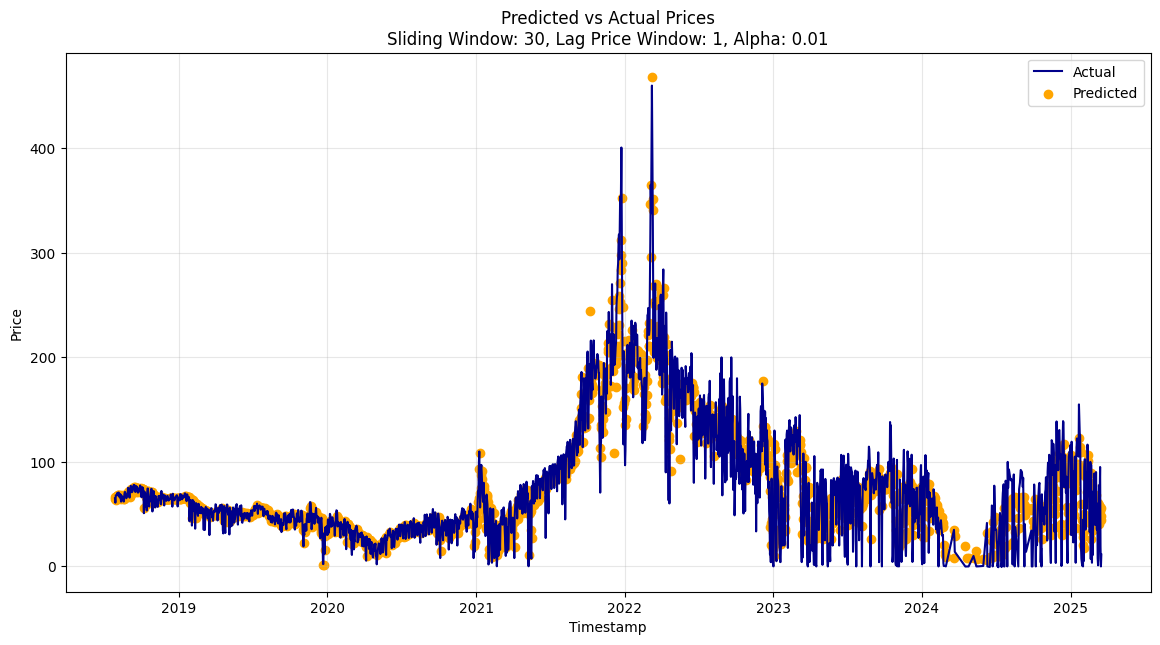

In [41]:
import matplotlib.pyplot as plt
# Plotting the predictions for the best model as scatter plot over the actuals as line plot
plt.figure(figsize=(14, 7))
plt.plot(prediction_df_best_baseline['Timestamp'], prediction_df_best_baseline['Actual'], label='Actual', color='darkblue')
plt.scatter(prediction_df_best_baseline['Timestamp'], prediction_df_best_baseline['Predicted'], label='Predicted', color='orange')
plt.title(f"Predicted vs Actual Prices\nSliding Window: {int(30)}, Lag Price Window: {int(1)}, Alpha: {0.01}")
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('lasso_baseline_best_model.png', dpi=300, bbox_inches='tight')
plt.show()


Feature engineering version:

In [ ]:
alphas = [0.01, 0.1, 1, 10]  # Lasso regularization parameters

from sklearn.linear_model import Lasso
# Initialize the regression model
model = Lasso()

for alpha in alphas:
    # Initialize comprehensive results list
    comprehensive_fe_results = []

    # Set the alpha parameter for Lasso
    model.set_params(alpha=alpha)
    print(f"\nRunning regression training with Lasso alpha: {alpha}")

    for sliding_window in sliding_windows:
        for lag_price_window in lag_price_windows:
            print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

            # Run the regression training
            prediction_df = regression_training(df, sliding_window, lag_price_window, DEBUG)
            
            # Calculate overall metrics
            actuals_list = prediction_df['Actual'].values
            predictions_list = prediction_df['Predicted'].values
            timestamps_list = prediction_df['Timestamp'].values

            mse = mean_squared_error(actuals_list, predictions_list)
            mae = mean_absolute_error(actuals_list, predictions_list)
            r2 = r2_score(actuals_list, predictions_list)
            
            # Expectation Shortfall - Calculate metrics for top X worst predictions
            # Calculate prediction errors for filtering
            prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

            # Add overall results (100% percentile)
            comprehensive_fe_results.append({
                'sliding_window': sliding_window,
                'lag_price_window': lag_price_window,
                'percentile': 100,
                'data_points': len(predictions_list),
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'avg_error': np.mean(prediction_errors)
            })
            
            for p in percentiles:
                # Filter by best predictions (lowest errors)
                best_error_threshold = np.percentile(prediction_errors, p)
                
                # Expectation Shortfall like metric - worst predictions analysis
                # Filter by best predictions (highest errors)
                worst_error_threshold = np.percentile(prediction_errors, 100 - p) # equivalent to worst_percentiles

                # Get indices of best/worst predictions 
                best_indices = prediction_errors <= best_error_threshold # with errors below threshold
                worst_indices = prediction_errors >= worst_error_threshold # with errors above threshold

                filtered_actuals = np.array(actuals_list)[best_indices]
                filtered_predictions = np.array(predictions_list)[best_indices]

                if len(filtered_actuals) > 0:
                    mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                    mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                    r2_p = r2_score(filtered_actuals, filtered_predictions)
                    avg_error_wp = np.mean(prediction_errors[worst_indices])

                    # Add to full comprehensive results
                    comprehensive_fe_results.append({
                        'sliding_window': sliding_window,
                        'lag_price_window': lag_price_window,
                        'percentile': p,
                        'data_points': len(filtered_predictions),
                        'mse': mse_p,
                        'mae': mae_p,
                        'r2': r2_p,
                        'worst_avg_error': avg_error_wp
                    })
                else:
                    # Add entry for no data available
                    comprehensive_fe_results.append({
                        'sliding_window': sliding_window,
                        'lag_price_window': lag_price_window,
                        'percentile': p,
                        'data_points': 0,
                        'mse': np.nan,
                        'mae': np.nan,
                        'r2': np.nan,
                        'worst_avg_error': np.nan
                    })
    # Save results to CSV
    results_df = pd.DataFrame(comprehensive_fe_results)
    results_df.to_csv(f"lasso_fe_results_alpha_{alpha}.csv", index=False)


Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 4
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 6
Number of models to train: 2252

Running regression training with sliding window: 10, price feature window: 1
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 2
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 4
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 6
Number of models to train: 2249

Running regression training with sliding window: 15, price feature window: 1
Number of models to train: 2244

Running regre

In [9]:
# Create comprehensive DataFrame
comprehensive_fe_df = pd.DataFrame(comprehensive_fe_results)

# Save to CSV
comprehensive_fe_df.to_csv('regression_fe_results.csv', index=False)
print(f"\nResults saved to 'regression_fe_results.csv'")


Results saved to 'regression_fe_results.csv'


In [71]:
# Determine the best performing model based on lowest MAE and 99th percentile
best_fe_model = comprehensive_fe_df.loc[comprehensive_fe_df['percentile'] == 99].sort_values(by='mae').iloc[0]
print("\nBest performing model based on lowest MAE:")
print(best_fe_model)


Best performing model based on lowest MAE:
sliding_window         7.000000
lag_price_window       6.000000
percentile            99.000000
data_points         2229.000000
mse                  592.975588
mae                   15.062360
r2                     0.819059
avg_error                   NaN
worst_avg_error       16.499300
Name: 16, dtype: float64


In [72]:
# Pareto frontier approach - find models that are best in multiple metrics
def find_pareto_optimal_models(df, percentile=99):
    """Find models that are optimal in at least one metric"""
    subset = df[df['percentile'] == percentile].copy()
    
    # Rank by each metric (lower rank = better)
    subset['mae_rank'] = subset['mae'].rank(ascending=True)
    subset['mse_rank'] = subset['mse'].rank(ascending=True)  # Lower MSE is better
    subset['r2_rank'] = subset['r2'].rank(ascending=False)  # Higher R² is better
    subset['worst_error_rank'] = subset['worst_avg_error'].rank(ascending=True)
    
    # Find average rank across all 4 metrics
    subset['avg_rank'] = (subset['mae_rank'] + subset['mse_rank'] + 
                         subset['r2_rank'] + subset['worst_error_rank']) / 4
    
    return subset.sort_values('avg_rank')

# Get top models by multiple criteria
pareto_fe = find_pareto_optimal_models(comprehensive_fe_df)

print("Top 3 models by multi-criteria ranking (including MSE):")
print(pareto_fe[['sliding_window', 'lag_price_window', 'mae', 'mse', 'r2', 'worst_avg_error', 'avg_rank']].head(3))

Top 3 models by multi-criteria ranking (including MSE):
    sliding_window  lag_price_window        mae          mse        r2  \
16               7                 6  15.062360   592.975588  0.819059   
81              90                 1  22.915602  1334.793068  0.616212   
86              90                 2  23.366797  1391.429769  0.601812   

    worst_avg_error  avg_rank  
16        16.499300       1.0  
81        35.295439       2.0  
86        37.588369       3.0  


In [69]:
# recalculate the best model predictions
best_fe_sliding_window = best_fe_model['sliding_window']
best_fe_lag_price_window = best_fe_model['lag_price_window']

print(f"Best Feature Engineering Model - Sliding Window: {best_fe_sliding_window}, Lag Price Window: {best_fe_lag_price_window}")

# Run the regression training for the best model
prediction_df_best_fe = regression_training(df, int(best_fe_sliding_window), int(best_fe_lag_price_window), DEBUG=False)

Best Feature Engineering Model - Sliding Window: 7.0, Lag Price Window: 6.0
Number of models to train: 2252


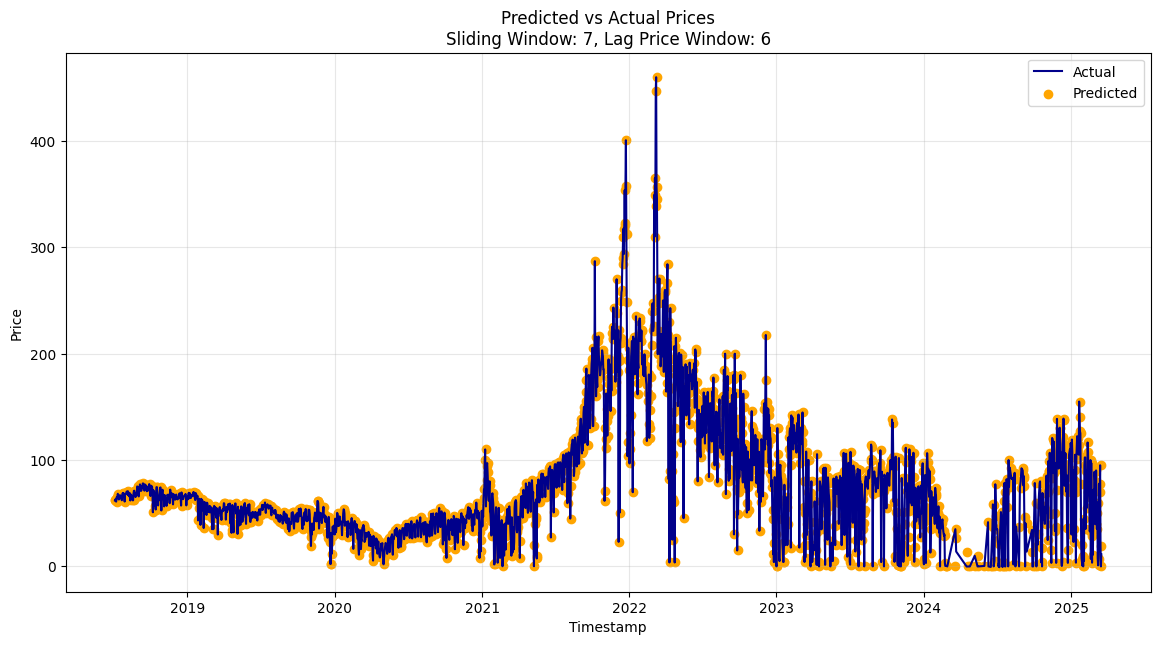

In [70]:
import matplotlib.pyplot as plt
# Plotting the predictions for the best model as scatter plot over the actuals as line plot
plt.figure(figsize=(14, 7))
plt.plot(prediction_df_best_fe['Timestamp'], prediction_df_best_fe['Actual'], label='Actual', color='darkblue')
plt.scatter(prediction_df_best_fe['Timestamp'], prediction_df_best_fe['Predicted'], label='Predicted', color='orange')
plt.title(f"Predicted vs Actual Prices\nSliding Window: {int(best_fe_model['sliding_window'])}, Lag Price Window: {int(best_fe_model['lag_price_window'])}")
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('regression_fe_best_model.png', dpi=300, bbox_inches='tight')
plt.show()